### References

* https://github.com/huggingface/transformers/blob/master/src/transformers/models/encoder_decoder/modeling_encoder_decoder.py

* https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101

* https://github.com/hiyoung123/SoftMaskedBert/blob/master/train.py

* https://github.com/atulkum/pointer_summarizer/blob/master/training_ptr_gen/model.py

* https://github.com/nyu-dl/bert-gen/blob/master/bert-babble.ipynb


In [1]:
!pip install transformers==4.0.1
!pip install nlpaug

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 387 kB 2.9 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import time
import datetime

import re
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

from tqdm import tqdm
import time
import random

import nlpaug.augmenter.char as nac

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM, \
                         AutoConfig, EncoderDecoderModel

from typing import Optional

from transformers import AdamW, get_linear_schedule_with_warmup

from transformers.configuration_utils import PretrainedConfig
from transformers.file_utils import add_start_docstrings, add_start_docstrings_to_model_forward, replace_return_docstrings
from transformers.modeling_outputs import Seq2SeqLMOutput
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import logging
from transformers.models.encoder_decoder.configuration_encoder_decoder import EncoderDecoderConfig
from transformers.models.auto.modeling_auto import AutoModel, AutoModelForCausalLM, AutoConfig

In [3]:
seed_val = 66
MIN_LEN = 20
MAX_LEN = 100
batch_size = 12
EPOCHS = 30
early_stopping_rounds = 5
lr = 5e-5

encoder_path = 'bert-base-uncased'
decoder_path = 'claudelkros/bert-base-french' #'bert-base-german-cased'

teacher_forcing=True

aug = nac.OcrAug()

In [4]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [5]:
torch.cuda.empty_cache()

In [6]:
# !cat ../input/denoising/NMT-data/commoncrawl.fr-en.en | wc -l
# !cat ../input/denoising/NMT-data/commoncrawl.fr-en.fr | wc -l


In [7]:
# train_input = open('../input/denoising/NMT-data/commoncrawl.fr-en.en', 'r').readlines()
# train_output = open('../input/denoising/NMT-data/commoncrawl.fr-en.fr', 'r').readlines()

In [8]:
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        nmt_data =  pd.read_csv(os.path.join(dirname, filename))

/kaggle/input/nmt-eng-french/NMT_denoisedData.csv


In [9]:
# train = pd.DataFrame()
# train['original'] = train_input
# train['solution'] = train_output

In [10]:
# train = train.iloc[:10000]

In [11]:
nmt_data.columns

Index(['Unnamed: 0', 'original', 'solution', 'char_augumented',
       'keyborad_augumented', 'random_augumented', 'substitute_augumented',
       'swap_augumented', 'delete_augumented', 'spell_augumented'],
      dtype='object')

In [12]:
train  = nmt_data[['delete_augumented','solution']]

In [13]:
train = train.rename(columns={"solution": "solution", "delete_augumented": "original"}, errors="raise")

In [14]:
train.head()

,original,solution
0,* - Main gods are maked with red colr.,* - les marchandises principales sont souligne...
1,* - Man srviss are marked ith red color.,* - les services principales sont soulignes pa...
2,ervies of laguae translation of the. ..,Services de traduction de la documentation...\n
3,An announmet must be commercial charter.,Les messages doivent porter le caractère d’aff...
4,Good and serics avanceme throg the P. O. Box s...,L’avance de ses marchandises et de ses service...


In [15]:
encoder_tokenizer = AutoTokenizer.from_pretrained(encoder_path)
decoder_tokenizer = AutoTokenizer.from_pretrained(decoder_path)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [16]:
train['text_len'] = train.original.apply(lambda x: len(encoder_tokenizer.encode(x, max_length=512, add_special_tokens=True)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [17]:
train.text_len.describe()

count    10000.000000
mean        35.847400
std         18.567951
min          8.000000
25%         22.000000
50%         32.000000
75%         46.000000
max        215.000000
Name: text_len, dtype: float64

In [18]:
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(train):
    break

In [19]:
val = train.iloc[val_index]
train = train.iloc[train_index]

In [20]:
trainX = torch.Tensor(np.asarray([encoder_tokenizer.encode(i, max_length=MAX_LEN, truncation=True, padding='max_length', add_special_tokens=True) \
                                  for i in tqdm(train.original.values)]))
trainy = torch.Tensor(np.asarray([decoder_tokenizer.encode(i, max_length=MAX_LEN, truncation=True, padding='max_length', add_special_tokens=True) \
                                  for i in tqdm(train.solution.values)]))

valX = torch.Tensor(np.asarray([encoder_tokenizer.encode(i, max_length=MAX_LEN, truncation=True, padding='max_length', add_special_tokens=True) \
                                for i in tqdm(val.original.values)]))
valy = torch.Tensor(np.asarray([decoder_tokenizer.encode(i, max_length=MAX_LEN, truncation=True, padding='max_length', add_special_tokens=True) \
                                for i in tqdm(val.solution.values)]))


100%|██████████| 2000/2000 [00:00<00:00, 3681.43it/s]


In [21]:
trainX.shape, trainy.shape, valX.shape, valy.shape

(torch.Size([8000, 100]),
 torch.Size([8000, 100]),
 torch.Size([2000, 100]),
 torch.Size([2000, 100]))

In [22]:
trainX = torch.tensor(trainX, dtype=torch.long)
trainy = torch.tensor(trainy, dtype=torch.long)
valX = torch.tensor(valX, dtype=torch.long)
valy = torch.tensor(valy, dtype=torch.long)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [23]:
logger = logging.get_logger(__name__)

_CONFIG_FOR_DOC = "EncoderDecoderConfig"

ENCODER_DECODER_START_DOCSTRING = r"""
    This class can be used to initialize a sequence-tsequencece model with any pretrained autoencoding model as the
    encoder and any pretrained autoregressive model as the decoder. The encoder is loaded via
    :meth:`~transformers.AutoModel.from_pretrained` function and the decoder is loaded via
    :meth:`~transformers.AutoModelForCausalLM.from_pretrained` function. Cross-attention layers are automatically added
    to the decoder and should be fine-tuned on a downstream generative task, like summarization.
    The effectiveness of initializing sequence-to-sequence models with pretrained checkpoints for sequence generation
    tasks was shown in `Leveraging Pre-trained Checkpoints for Sequence Generation Tasks
    <https://arxiv.org/abs/1907.12461>`__ by Sascha Rothe, Shashi Narayan, Aliaksei Severyn. Michael Matena, Yanqi
    Zhou, Wei Li, Peter J. Liu.
    After such an Encoder Decoder model has been trained/fine-tuned, it can be saved/loaded just like any other models
    (see the examples for more information).
    This model inherits from :class:`~transformers.PreTrainedModel`. Check the superclass documentation for the generic
    methods the library implements for all its model (such as downloading or saving, resizing the input embeddings,
    pruning heads etc.)
    This model is also a PyTorch `torch.nn.Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`__
    subclass. Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to
    general usage and behavior.
    Parameters:
        config (:class:`~transformers.T5Config`): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the :meth:`~transformers.PreTrainedModel.from_pretrained` method to load the model
            weights.
"""

ENCODER_DECODER_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary.
            Indices can be obtained using :class:`~transformers.PreTrainedTokenizer`. See
            :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__` for
            details.
            `What are input IDs? <../glossary.html#input-ids>`__
        attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on padding token indices. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
            `What are attention masks? <../glossary.html#attention-mask>`__
        decoder_input_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, target_sequence_length)`, `optional`):
            Provide for sequence to sequence training to the decoder. Indices can be obtained using
            :class:`~transformers.PretrainedTokenizer`. See :meth:`transformers.PreTrainedTokenizer.encode` and
            :meth:`transformers.PreTrainedTokenizer.__call__` for details.
        decoder_attention_mask (:obj:`torch.BoolTensor` of shape :obj:`(batch_size, tgt_seq_len)`, `optional`):
            Default behavior: generate a tensor that ignores pad tokens in :obj:`decoder_input_ids`. Causal mask will
            also be used by default.
        encoder_outputs (:obj:`tuple(torch.FloatTensor)`, `optional`):
            This tuple must consist of (:obj:`last_hidden_state`, `optional`: :obj:`hidden_states`, `optional`:
            :obj:`attentions`) :obj:`last_hidden_state` (:obj:`torch.FloatTensor` of shape :obj:`(batch_size,
            sequence_length, hidden_size)`) is a tensor of hidden-states at the output of the last layer of the
            encoder. Used in the cross-attention of the decoder.
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded representation.
            This is useful if you want more control over how to convert :obj:`input_ids` indices into associated
            vectors than the model's internal embedding lookup matrix.
        decoder_inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, target_sequence_length, hidden_size)`, `optional`):
            Optionally, instead of passing :obj:`decoder_input_ids` you can choose to directly pass an embedded
            representation. This is useful if you want more control over how to convert :obj:`decoder_input_ids`
            indices into associated vectors than the model's internal embedding lookup matrix.
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the masked language modeling loss for the decoder. Indices should be in ``[-100, 0,
            ..., config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are ignored
            (masked), the loss is only computed for the tokens with labels in ``[0, ..., config.vocab_size]``
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        output_attentions (:obj:`bool`, `optional`):
            Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under returned
            tensors for more detail.
        output_hidden_states (:obj:`bool`, `optional`):
            Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors for
            more detail.
        return_dict (:obj:`bool`, `optional`):
            If set to ``True``, the model will return a :class:`~transformers.file_utils.Seq2SeqLMOutput` instead of a
            plain tuple.
        kwargs: (`optional`) Remaining dictionary of keyword arguments. Keyword arguments come in two flavors:
            - Without a prefix which will be input as ``**encoder_kwargs`` for the encoder forward function.
            - With a `decoder_` prefix which will be input as ``**decoder_kwargs`` for the decoder forward function.
"""

@add_start_docstrings(ENCODER_DECODER_START_DOCSTRING)
class EncoderDecoderModelWithGates(PreTrainedModel):
    r"""
    :class:`~transformers.EncoderDecoder` is a generic model class that will be instantiated as a transformer
    architecture with one of the base model classes of the library as encoder and another one as decoder when created
    with the :meth`~transformers.AutoModel.from_pretrained` class method for the encoder and
    :meth`~transformers.AutoModelForCausalLM.from_pretrained` class method for the decoder.
    """
    config_class = EncoderDecoderConfig
    base_model_prefix = "encoder_decoder"

    def __init__(
        self,
        config: Optional[PretrainedConfig] = None,
        encoder: Optional[PreTrainedModel] = None,
        decoder: Optional[PreTrainedModel] = None,
    ):
        
        assert config is not None or (
            encoder is not None and decoder is not None
        ), "Either a configuration or an Encoder and a decoder has to be provided"
        if config is None:
            config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder.config, decoder.config)
        else:
            assert isinstance(config, self.config_class), "config: {} has to be of type {}".format(
                config, self.config_class
            )
        # initialize with config
        super().__init__(config)

        if encoder is None:
            

            encoder = AutoModel.from_config(config.encoder)

        if decoder is None:
            

            decoder = AutoModelForCausalLM.from_config(config.decoder)

        tokenizer = AutoTokenizer.from_pretrained(config.encoder._name_or_path)
            
        self.encoder = encoder
        self.decoder = decoder
        assert (
            self.encoder.get_output_embeddings() is None
        ), "The encoder {} should not have a LM Head. Please use a model without LM Head"

        # tie encoder, decoder weights if config set accordingly
        self.tie_weights()
        
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.embedding = self.encoder.embeddings
        
        self.mask_gate = nn.Linear(config.encoder.hidden_size, 1, bias=False)
        self.copy_gate = nn.Linear(config.decoder.hidden_size, 1, bias=False)
        self.generate_gate = nn.Linear(config.decoder.hidden_size, 1, bias=False)
        self.skip_gate = nn.Linear(config.decoder.hidden_size, 1, bias=False)
        
        
    def tie_weights(self):
        # tie encoder & decoder if needed
        if self.config.tie_encoder_decoder:
            # tie encoder and decoder base model
            decoder_base_model_prefix = self.decoder.base_model_prefix
            self._tie_encoder_decoder_weights(
                self.encoder, self.decoder._modules[decoder_base_model_prefix], self.decoder.base_model_prefix
            )

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def get_input_embeddings(self):
        return self.encoder.get_input_embeddings()

    def get_output_embeddings(self):
        return self.decoder.get_output_embeddings()

    def set_output_embeddings(self, new_embeddings):
        return self.decoder.set_output_embeddings(new_embeddings)

    @classmethod
    def from_encoder_decoder_pretrained(
        cls,
        encoder_pretrained_model_name_or_path: str = None,
        decoder_pretrained_model_name_or_path: str = None,
        *model_args,
        **kwargs
    ) -> PreTrainedModel:
        r"""
        Instantiate an encoder and a decoder from one or two base classes of the library from pretrained model
        checkpoints.
        The model is set in evaluation mode by default using :obj:`model.eval()` (Dropout modules are deactivated). To
        train the model, you need to first set it back in training mode with :obj:`model.train()`.
        Params:
            encoder_pretrained_model_name_or_path (:obj: `str`, `optional`):
                Information necessary to initiate the encoder. Can be either:
                    - A string, the `model id` of a pretrained model hosted inside a model repo on huggingface.co.
                      Valid model ids can be located at the root-level, like ``bert-base-uncased``, or namespaced under
                      a user or organization name, like ``dbmdz/bert-base-german-cased``.
                    - A path to a `directory` containing model weights saved using
                      :func:`~transformers.PreTrainedModel.save_pretrained`, e.g., ``./my_model_directory/``.
                    - A path or url to a `tensorflow index checkpoint file` (e.g, ``./tf_model/model.ckpt.index``). In
                      this case, ``from_tf`` should be set to :obj:`True` and a configuration object should be provided
                      as ``config`` argument. This loading path is slower than converting the TensorFlow checkpoint in
                      a PyTorch model using the provided conversion scripts and loading the PyTorch model afterwards.
            decoder_pretrained_model_name_or_path (:obj: `str`, `optional`, defaults to `None`):
                Information necessary to initiate the decoder. Can be either:
                    - A string, the `model id` of a pretrained model hosted inside a model repo on huggingface.co.
                      Valid model ids can be located at the root-level, like ``bert-base-uncased``, or namespaced under
                      a user or organization name, like ``dbmdz/bert-base-german-cased``.
                    - A path to a `directory` containing model weights saved using
                      :func:`~transformers.PreTrainedModel.save_pretrained`, e.g., ``./my_model_directory/``.
                    - A path or url to a `tensorflow index checkpoint file` (e.g, ``./tf_model/model.ckpt.index``). In
                      this case, ``from_tf`` should be set to :obj:`True` and a configuration object should be provided
                      as ``config`` argument. This loading path is slower than converting the TensorFlow checkpoint in
                      a PyTorch model using the provided conversion scripts and loading the PyTorch model afterwards.
            model_args (remaining positional arguments, `optional`):
                All remaning positional arguments will be passed to the underlying model's ``__init__`` method.
            kwargs (remaining dictionary of keyword arguments, `optional`):
                Can be used to update the configuration object (after it being loaded) and initiate the model (e.g.,
                :obj:`output_attentions=True`).
                - To update the encoder configuration, use the prefix `encoder_` for each configuration parameter.
                - To update the decoder configuration, use the prefix `decoder_` for each configuration parameter.
                - To update the parent model configuration, do not use a prefix for each configuration parameter.
                Behaves differently depending on whether a :obj:`config` is provided or automatically loaded.
        Example::
            >>> from transformers import EncoderDecoderModel
            >>> # initialize a bert2bert from two pretrained BERT models. Note that the cross-attention layers will be randomly initialized
            >>> model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased')
            >>> # saving model after fine-tuning
            >>> model.save_pretrained("./bert2bert")
            >>> # load fine-tuned model
            >>> model = EncoderDecoderModel.from_pretrained("./bert2bert")
        """

        kwargs_encoder = {
            argument[len("encoder_") :]: value for argument, value in kwargs.items() if argument.startswith("encoder_")
        }

        kwargs_decoder = {
            argument[len("decoder_") :]: value for argument, value in kwargs.items() if argument.startswith("decoder_")
        }

        # remove encoder, decoder kwargs from kwargs
        for key in kwargs_encoder.keys():
            del kwargs["encoder_" + key]
        for key in kwargs_decoder.keys():
            del kwargs["decoder_" + key]

        # Load and initialize the encoder and decoder
        # The distinction between encoder and decoder at the model level is made
        # by the value of the flag `is_decoder` that we need to set correctly.
        encoder = kwargs_encoder.pop("model", None)
        if encoder is None:
            assert (
                encoder_pretrained_model_name_or_path is not None
            ), "If `model` is not defined as an argument, a `encoder_pretrained_model_name_or_path` has to be defined"

            if "config" not in kwargs_encoder:

                encoder_config = AutoConfig.from_pretrained(encoder_pretrained_model_name_or_path)
                if encoder_config.is_decoder is True or encoder_config.add_cross_attention is True:

                    logger.info(
                        f"Initializing {encoder_pretrained_model_name_or_path} as a encoder model from a decoder model. Cross-attention and casual mask are disabled."
                    )
                    encoder_config.is_decoder = False
                    encoder_config.add_cross_attention = False

                kwargs_encoder["config"] = encoder_config

            encoder = AutoModel.from_pretrained(encoder_pretrained_model_name_or_path, *model_args, **kwargs_encoder)

        decoder = kwargs_decoder.pop("model", None)
        if decoder is None:
            assert (
                decoder_pretrained_model_name_or_path is not None
            ), "If `decoder_model` is not defined as an argument, a `decoder_pretrained_model_name_or_path` has to be defined"

            if "config" not in kwargs_decoder:

                decoder_config = AutoConfig.from_pretrained(decoder_pretrained_model_name_or_path)
                if decoder_config.is_decoder is False or decoder_config.add_cross_attention is False:
                    logger.info(
                        f"Initializing {decoder_pretrained_model_name_or_path} as a decoder model. Cross attention layers are added to {decoder_pretrained_model_name_or_path} and randomly initialized if {decoder_pretrained_model_name_or_path}'s architecture allows for cross attention layers."
                    )
                    decoder_config.is_decoder = True
                    decoder_config.add_cross_attention = True

                kwargs_decoder["config"] = decoder_config

            if kwargs_decoder["config"].is_decoder is False or kwargs_decoder["config"].add_cross_attention is False:
                logger.warning(
                    f"Decoder model {decoder_pretrained_model_name_or_path} is not initialized as a decoder. In order to initialize {decoder_pretrained_model_name_or_path} as a decoder, make sure that the attributes `is_decoder` and `add_cross_attention` of `decoder_config` passed to `.from_encoder_decoder_pretrained(...)` are set to `True` or do not pass a `decoder_config` to `.from_encoder_decoder_pretrained(...)`"
                )

            decoder = AutoModelForCausalLM.from_pretrained(decoder_pretrained_model_name_or_path, **kwargs_decoder)

        # instantiate config with corresponding kwargs
        config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder.config, decoder.config, **kwargs)
        return cls(encoder=encoder, decoder=decoder, config=config)

    @add_start_docstrings_to_model_forward(ENCODER_DECODER_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=Seq2SeqLMOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        encoder_mask_token_id,
        decoder_mask_token_id,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,  # TODO: (PVP) implement :obj:`use_cache`
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,  # TODO: (PVP) implement :obj:`use_cache`
        output_attentions=None,
        output_hidden_states=True,
        return_dict=None,
        **kwargs,
    ):
        r"""
        Returns:
        Examples::
            >>> from transformers import EncoderDecoderModel, BertTokenizer
            >>> import torch
            >>> tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            >>> model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased') # initialize Bert2Bert from pre-trained checkpoints
            >>> # forward
            >>> input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
            >>> outputs = model(input_ids=input_ids, decoder_input_ids=input_ids)
            >>> # training
            >>> outputs = model(input_ids=input_ids, decoder_input_ids=input_ids, labels=input_ids)
            >>> loss, logits = outputs.loss, outputs.logits
            >>> # save and load from pretrained
            >>> model.save_pretrained("bert2bert")
            >>> model = EncoderDecoderModel.from_pretrained("bert2bert")
            >>> # generation
            >>> generated = model.generate(input_ids, decoder_start_token_id=model.config.decoder.pad_token_id)
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        kwargs_encoder = {argument: value for argument, value in kwargs.items() if not argument.startswith("decoder_")}

        kwargs_decoder = {
            argument[len("decoder_") :]: value for argument, value in kwargs.items() if argument.startswith("decoder_")
        }

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
                **kwargs_encoder,
            )

        mask_e = self.embedding(encoder_mask_token_id)
        
        encoder_hidden_states = encoder_outputs[0]
        
        masking_prob = F.sigmoid(self.mask_gate(encoder_hidden_states))
        
        encoder_hidden_states = masking_prob * mask_e + (1-masking_prob)*encoder_hidden_states
        
        
        #encoder_hidden_states = 
        
        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            **kwargs_decoder,
        )
        
        #print (decoder_outputs.logits.shape)
        decoder_hidden_states = decoder_outputs.hidden_states[-1]
        
        copy_prob = F.sigmoid(self.copy_gate(decoder_hidden_states))
        
        generate_prob = F.sigmoid(self.generate_gate(decoder_hidden_states))
        
        decoder_input_one_hot = torch.nn.functional.one_hot(decoder_input_ids, num_classes=self.config.decoder.vocab_size)
        
        stacks = nn.Softmax(dim=0)(torch.stack([copy_prob.unsqueeze(0),generate_prob.unsqueeze(0)]))
        copy_prob = stacks[0]
        generate_prob = stacks[1]
        
        logits = generate_prob*decoder_outputs.logits + copy_prob*decoder_input_one_hot
        #logits = decoder_outputs.logits
        logits = nn.LogSoftmax(dim=-1)(logits)
        
        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            
            #loss_fn = nn.NLLLoss()
            #loss = loss = loss_fn(logits.transpose(1, 2), labels)
        else:
            loss = None
            
        # TODO(PVP): currently it is not possible to use `past`
        if not return_dict:
            return decoder_outputs + encoder_outputs
            #print ("inside loop")
            #return (1-copy_prob)*decoder_outputs + copy_prob*encoder_outputs
    
        #print (decoder_outputs.hidden_states.shape)
        #print (encoder_outputs.last_hidden_state.shape)
        #print (encoder_outputs.hidden_states.shape)
        
        return Seq2SeqLMOutput(
            loss=loss,
            logits=logits,
            past_key_values=None,  # TODO(PVP) - need to implement cache for BERT, etc... before this works
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        ), generate_prob, copy_prob, masking_prob

    def prepare_inputs_for_generation(self, input_ids, past=None, attention_mask=None, encoder_outputs=None, **kwargs):
        decoder_inputs = self.decoder.prepare_inputs_for_generation(input_ids)
        decoder_attention_mask = decoder_inputs["attention_mask"] if "attention_mask" in decoder_inputs else None
        input_dict = {
            "attention_mask": attention_mask,
            "decoder_attention_mask": decoder_attention_mask,
            "decoder_input_ids": decoder_inputs["input_ids"],
            "encoder_outputs": encoder_outputs,
        }

        # Ideally all models should have a :obj:`use_cache`
        # leave following to ifs until all have it implemented
        if "use_cache" in decoder_inputs:
            input_dict["decoder_use_cache"] = decoder_inputs["use_cache"]

        if "past_key_values" in decoder_inputs:
            input_dict["past_key_values"] = decoder_inputs["past_key_values"]

        return input_dict

    def _reorder_cache(self, past, beam_idx):
        # apply decoder cache reordering here
        return self.decoder._reorder_cache(past, beam_idx)

In [24]:
model = EncoderDecoderModelWithGates.from_encoder_decoder_pretrained(encoder_path, decoder_path)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/441M [00:00<?, ?B/s]

Some weights of the model checkpoint at claudelkros/bert-base-french were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at claudelkros/bert-base-french and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.key.bias

In [25]:
model.config.encoder.max_length = MAX_LEN
model.config.decoder.max_length = MAX_LEN

model.config.encoder.min_length = MIN_LEN
model.config.decoder.min_length = MIN_LEN

In [26]:
train_data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(trainX, trainy), batch_size=batch_size)

val_data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(valX, valy), batch_size=batch_size)

print ("Train and val loader length {} and {}".format(len(train_data_loader), len(val_data_loader)))

Train and val loader length 667 and 167


In [27]:
print ("Modeling")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("Device: {}".format(device))

model = model.to(device)

params = list(model.named_parameters())

optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Modeling
Device: cuda


In [28]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.cuda.empty_cache()

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

bad_epochs = 0
best_val_logits = 0

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    if bad_epochs < early_stopping_rounds:
        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_data_loader):

            # Progress update every 40 batches.
            if step % 60 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.  Loss: {}'.format(step, len(train_data_loader), elapsed, loss.item()))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            input_ids = batch[0].to(device)
            output_ids = batch[1].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # are given and what flags are set. For our usage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            if teacher_forcing:
                outputs, _, _, _ = model(encoder_mask_token_id = torch.tensor([[encoder_tokenizer.mask_token_id]]).to(device),\
                                     decoder_mask_token_id = decoder_tokenizer.mask_token_id, \
                            input_ids=input_ids, decoder_input_ids=output_ids, labels=output_ids, return_dict=True)
            else:
                outputs, _, _, _ = model(encoder_mask_token_id = torch.tensor([[encoder_tokenizer.mask_token_id]]).to(device),\
                                     decoder_mask_token_id = decoder_tokenizer.mask_token_id, \
                            input_ids=input_ids, decoder_input_ids=input_ids, labels=output_ids, return_dict=True)
                
            loss, logits = outputs.loss, outputs.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_data_loader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_loss = 0
        nb_eval_steps = 0

        all_val_logits = []
        
        # Evaluate data for one epoch
        for batch in val_data_loader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            input_ids = batch[0].to(device)
            output_ids = batch[1].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                if teacher_forcing:
                    outputs, _, _, _ = model(encoder_mask_token_id = torch.tensor([[encoder_tokenizer.mask_token_id]]).to(device),\
                                     decoder_mask_token_id = decoder_tokenizer.mask_token_id, \
                            input_ids=input_ids, decoder_input_ids=output_ids, labels=output_ids, return_dict=True)
                else:
                    outputs, _, _, _ = model(encoder_mask_token_id = torch.tensor([[encoder_tokenizer.mask_token_id]]).to(device),\
                                     decoder_mask_token_id = decoder_tokenizer.mask_token_id, \
                            input_ids=input_ids, decoder_input_ids=input_ids, labels=output_ids, return_dict=True)
                
                loss, logits = outputs.loss, outputs.logits


            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()

            all_val_logits.extend(logits.argmax(-1))
            
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(val_data_loader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        if epoch_i >= 1:
            if avg_val_loss < training_stats[-1]['Valid. Loss']:
                #model.save_pretrained('Bert2Bert_denoise')
                torch.save(model.state_dict(), 'gated_Bert2Bert_denoise.bin')
                bad_epochs = 0
                best_val_logits = all_val_logits.copy()
            else:
                bad_epochs += 1

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    else:
        print ("Early stopping!!")
        break

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 30 ========
Training...


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  Batch    60  of    667.    Elapsed: 0:00:30.  Loss: 5.347727298736572
  Batch   120  of    667.    Elapsed: 0:00:58.  Loss: 3.0147409439086914
  Batch   180  of    667.    Elapsed: 0:01:26.  Loss: 2.2709271907806396
  Batch   240  of    667.    Elapsed: 0:01:53.  Loss: 2.39750337600708
  Batch   300  of    667.    Elapsed: 0:02:21.  Loss: 1.7687190771102905
  Batch   360  of    667.    Elapsed: 0:02:49.  Loss: 2.0296685695648193
  Batch   420  of    667.    Elapsed: 0:03:17.  Loss: 1.3924006223678589
  Batch   480  of    667.    Elapsed: 0:03:44.  Loss: 1.8733313083648682
  Batch   540  of    667.    Elapsed: 0:04:12.  Loss: 1.45451819896698
  Batch   600  of    667.    Elapsed: 0:04:40.  Loss: 1.5806761980056763
  Batch   660  of    667.    Elapsed: 0:05:08.  Loss: 1.7150425910949707

  Average training loss: 2.65
  Training epcoh took: 0:05:11

Running Validation...
  Validation Loss: 2.43
  Validation took: 0:00:45

======== Epoch 2 / 30 ========
Training...
  Batch    60  of    6

In [29]:
#model.load_state_dict(torch.load('BERT_denoise.bin'))

In [30]:
with open('training_stats.txt','w') as f:
    for l in training_stats:
        f.write(str(l))
        f.write('\n')

In [31]:
for batch in val_data_loader:
    input_ids = batch[0].to(device)
    output_ids = batch[1].to(device)
    break

with torch.no_grad():        
    outputs, generate_prob, copy_prob, masking_prob = model(encoder_mask_token_id = torch.tensor([[encoder_tokenizer.mask_token_id]]).to(device), \
                                                            decoder_mask_token_id = decoder_tokenizer.mask_token_id, \
                    input_ids=input_ids, decoder_input_ids=input_ids, labels=output_ids, return_dict=True)
    loss, logits = outputs.loss, outputs.logits

In [32]:
original_texts = [decoder_tokenizer.decode(i) for i in output_ids.detach().cpu().numpy()]
predicted_texts = [decoder_tokenizer.decode(i) for i in logits.detach().cpu().numpy().argmax(axis=-1)[0]]

In [33]:
print ("original text ", original_texts[0])
print ("predicted text ", predicted_texts[0])

original text  [CLS] * - les marchandises principales sont soulignes par la couleur rouge. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
predicted text  il les futen dansina,, auitlation a [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [34]:
predicted_texts = []

for i in best_val_logits:
    for j in i:
        text = decoder_tokenizer.decode(j).split()
        text = [k for k in text if k not in ['[CLS]','[SEP]','[PAD]']]
        predicted_texts.append(" ".join(text).strip())

In [35]:
val['predicted_text'] = predicted_texts

In [36]:
import numpy as np
import  nltk.translate.bleu_score as bleu

In [37]:
def WRR(text1,text2):
    a = set(text1.lower().split())
    b = set(text2.lower().split())
    
    if (len(a) == 0) and (len(b) == 0):
        return .5
    
    c = a.intersection(b)
    return float(len(c))/(len(a) + len(b) - len(c))

def levenshtein(seq1, seq2):
    seq1 = seq1.lower()
    seq2 = seq2.lower()
    
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    #print (matrix)
    return (matrix[size_x - 1, size_y - 1])

def CRR(text1, text2):
    try:
        return 1 - float(levenshtein(text1,text2))/max(len(text1),len(text2))
    except:
        return 0

def bleu_score(text1,text2):
    return bleu.sentence_bleu([text1.lower().split()],text2.lower().split())

In [38]:
val['text_len'] = val.original.apply(lambda x: len(encoder_tokenizer.encode(x, max_length=512, add_special_tokens=True)))
val = val[val.text_len < MAX_LEN].reset_index(drop=True)

In [39]:
val['BLEU'] = val.apply(lambda x: bleu_score(x.predicted_text, x.solution), axis=1)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [40]:
val.BLEU.describe()

count    1994.000000
mean        0.459260
std         0.216429
min         0.000000
25%         0.427287
50%         0.537285
75%         0.604275
max         0.759836
Name: BLEU, dtype: float64

In [41]:
#val.to_csv('outputs.csv',index=False,sep='\t')

In [42]:
#device = torch.device('cpu')

all_generate_probs = []
all_copy_probs = []
all_masking_probs = []

for batch in tqdm(val_data_loader):
    input_ids = batch[0].to(device)
    output_ids = batch[1].to(device)

    with torch.no_grad():        
        outputs, generate_prob, copy_prob, masking_prob = model(encoder_mask_token_id = torch.tensor([[encoder_tokenizer.mask_token_id]]).to(device), \
                                                                decoder_mask_token_id = decoder_tokenizer.mask_token_id, \
                        input_ids=input_ids, decoder_input_ids=input_ids, labels=output_ids, return_dict=True)
        loss, logits = outputs.loss, outputs.logits
        
    all_generate_probs.append(generate_prob[0,:,:,0].cpu().numpy())
    all_copy_probs.append(copy_prob[0,:,:,0].cpu().numpy())
    all_masking_probs.append(masking_prob[:,:,0].cpu().numpy())
    
    

  0%|          | 0/167 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 167/167 [00:20<00:00,  8.27it/s]


In [43]:
all_generate_probs = np.concatenate(all_generate_probs, axis=0)
all_copy_probs = np.concatenate(all_copy_probs, axis=0)
all_masking_probs = np.concatenate(all_masking_probs, axis=0)


In [44]:
# val['text_len'] = val.original.apply(lambda x: len(encoder_tokenizer.encode(x, max_length=512, add_special_tokens=True)))
indices = val[val.text_len < MAX_LEN].index

In [45]:
all_generate_probs[indices].mean(1)

array([0.73086226, 0.7308846 , 0.73086095, ..., 0.7308932 , 0.7308421 ,
       0.7308895 ], dtype=float32)

In [46]:
# outputs['mean_generate_prob'] = all_generate_probs[indices].mean(1)
# outputs['mean_copy_prob'] = all_copy_probs[indices].mean(1)
# outputs['mean_mask_prob'] = all_masking_probs[indices].mean(1)
# outputs['max_mask_prob'] = all_masking_probs[indices].max(1)


In [47]:
val['mean_generate_prob'] = all_generate_probs[indices].mean(1)
val['mean_copy_prob'] = all_copy_probs[indices].mean(1)
val['mean_mask_prob'] = all_masking_probs[indices].mean(1)
val['max_mask_prob'] = all_masking_probs[indices].max(1)


In [48]:
val.to_csv('nmt_german_gated_BERT_probs_delete_augumented.csv',index=False)

In [49]:
#outputs[['WRR_1','BLEU_1','mean_mask_prob','max_mask_prob']].corr()

In [50]:
val[['BLEU','mean_mask_prob','max_mask_prob']].corr()

,BLEU,mean_mask_prob,max_mask_prob
BLEU,1.000000,-0.021836,-0.022322
mean_mask_prob,-0.021836,1.000000,0.550090
max_mask_prob,-0.022322,0.550090,1.000000


In [51]:
#val[['BLEU','mean_mask_prob','max_mask_prob']].corr()

In [52]:
val.head()

,original,solution,text_len,predicted_text,BLEU,mean_generate_prob,mean_copy_prob,mean_mask_prob,max_mask_prob
0,* - Main gods are maked with red colr.,* - les marchandises principales sont souligne...,14,le le il commentauxes dees sont conigne de le ...,0.501384,0.730862,0.269138,0.526952,0.739248
1,* - Man srviss are marked ith red color.,* - les services principales sont soulignes pa...,15,le le il comment dees det conignent par le car...,0.501384,0.730885,0.269115,0.549434,0.793300
2,ervies of laguae translation of the. ..,Services de traduction de la documentation...\n,14,"le de lavauci de l cart,",0.759836,0.730861,0.269139,0.514360,0.604807
3,An announmet must be commercial charter.,Les messages doivent porter le caractère d’aff...,11,"le pro devent un unurctere d'appes, de",0.594604,0.730850,0.269150,0.514300,0.652102
4,Good and serics avanceme throg the P. O. Box s...,L’avance de ses marchandises et de ses service...,23,"le'hotelit de ls enauxes, de las en en leure d...",0.707107,0.730838,0.269162,0.584878,0.670433


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt


In [54]:
# sns.regplot(outputs.WRR_1, outputs.mean_mask_prob)
# plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


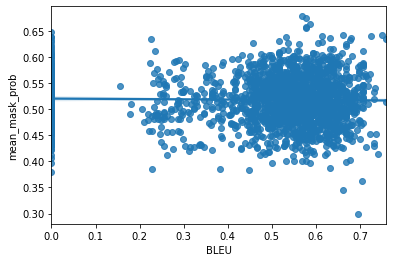

In [55]:
sns.regplot(val.BLEU, val.mean_mask_prob)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


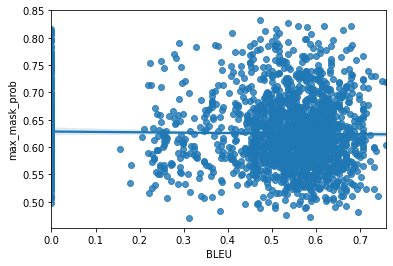

In [56]:
sns.regplot(val.BLEU, val.max_mask_prob)
plt.show()